In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from PIL import Image


import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import image_dataset_from_directory
from tensorflow.data import Dataset

from keras.metrics import Precision, Recall
import random
import matplotlib.image as mpimg

In [3]:

path = '/content/drive/MyDrive/Colab Notebooks/Data'

In [4]:
#generate data object keras
data = image_dataset_from_directory(path, label_mode= "categorical")

scaled_data = data.map(lambda x,y: (x/255,y))

#access data from keras data object
data_iterator= data.as_numpy_iterator()

#image batches as np arrays
batch= data_iterator.next()

Found 38606 files belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


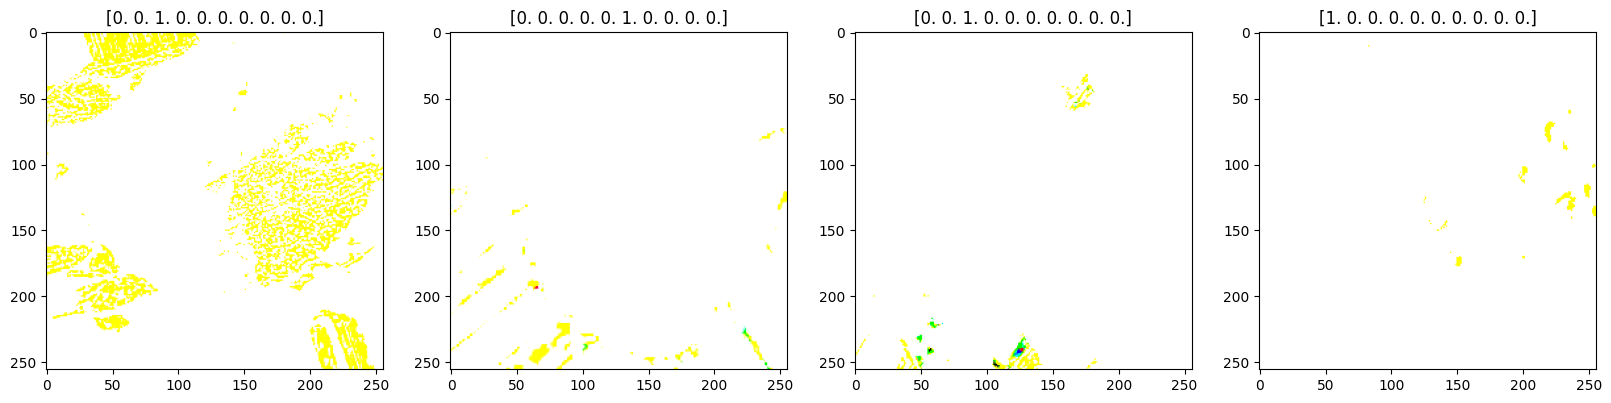

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [6]:
train_size = int(len(data)*.75)
val_size = int(len(data)*.2)
test_size = int(len(data)*.05)

In [7]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [19]:
pre_model = keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling= "avg" ,
    classes=10,
    classifier_activation='softmax'
)

for layer in pre_model.layers:
    layer.trainable = False

model = Sequential()
model.add(pre_model)



model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(10, activation='softmax'))


80134624/80134624 [==============================] - 4s 0us/step


In [20]:
model.compile('adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 20189898 (77.02 MB)
Trainable params: 165514 (646.54 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [21]:

hist = model.fit(train, epochs=5, validation_data=val)

model.save("model.keras")
print("model saved")

Epoch 1/5
905/905 [==============================] - 56s 58ms/step - loss: 0.1632 - accuracy: 0.9474 - val_loss: 0.0633 - val_accuracy: 0.9789
Epoch 2/5
905/905 [==============================] - 52s 58ms/step - loss: 0.0525 - accuracy: 0.9825 - val_loss: 0.0479 - val_accuracy: 0.9830
Epoch 3/5
905/905 [==============================] - 52s 58ms/step - loss: 0.0313 - accuracy: 0.9895 - val_loss: 0.0876 - val_accuracy: 0.9721
Epoch 4/5
905/905 [==============================] - 52s 58ms/step - loss: 0.0339 - accuracy: 0.9884 - val_loss: 0.0428 - val_accuracy: 0.9850
Epoch 5/5
905/905 [==============================] - 52s 58ms/step - loss: 0.0241 - accuracy: 0.9921 - val_loss: 0.0253 - val_accuracy: 0.9911
model saved


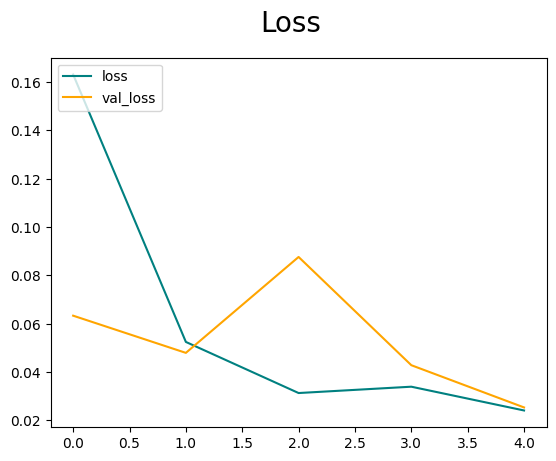

In [22]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

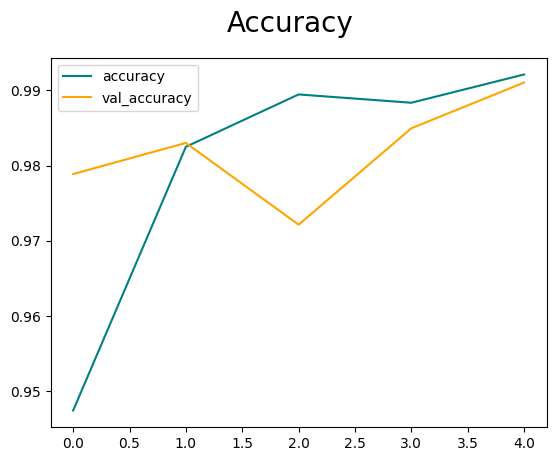

In [23]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Precision, Recall ve F1 Score hesaplama
y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(yhat, axis=1).numpy())

precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)



1/1 [==============================] - 0s 30ms/step


In [ ]:
# Sonuçları tablo şeklinde gösterme
metrics_df = pd.DataFrame({'Class': range(10), 'Precision': precision, 'Recall': recall, 'F1 Score': f1})
print(metrics_df)

# Confusion Matrix çizme
cm = confusion_matrix(y_true, y_pred)
class_names =  os.listdir(path)
class_names = sorted(class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()